# Install & Import Libraries

In [1]:
! pip install datasets
! pip install nltk

In [2]:
from datasets import load_dataset
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import random
import pickle

# Loading & Exploring Data

In [3]:
ds = load_dataset("asas-ai/ANERCorp")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['word', 'tag'],
        num_rows: 125102
    })
    test: Dataset({
        features: ['word', 'tag'],
        num_rows: 25008
    })
})

In [5]:
ds['train']

Dataset({
    features: ['word', 'tag'],
    num_rows: 125102
})

In [6]:
ds['train'][0]

{'word': 'فرانكفورت', 'tag': 'B-LOC'}

In [7]:
df_train = pd.DataFrame(ds['train'])

In [8]:
df_test = pd.DataFrame(ds['test'])

In [9]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [10]:
df

,word,tag
0,فرانكفورت,B-LOC
1,(د,O
2,ب,O
3,أ),O
4,أعلن,O
...,...,...
150105,الشخصية,O
150106,للوليد,B-PERS
150107,بن,I-PERS
150108,طلال,I-PERS


# Data Preprocessing

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stop_words = set(stopwords.words('arabic'))
filtered_data = [(word, tag) for word, tag in zip(df['word'], df['tag']) if word not in stop_words]
df = pd.DataFrame(filtered_data, columns=['word', 'tag'])

In [13]:
punctuations = set(string.punctuation)
arabic_punctuations = {'،', '؛', '؟', '«', '»', '“', '”', '‘', '’', '…', 'ـ'}
punctuations.update(arabic_punctuations)
punctuations.discard('.')
df = df[~df['word'].isin(punctuations)].copy()

In [14]:
def remove_punct(word):
    return re.sub(rf"[{re.escape(''.join(punctuations))}]", "", word)

In [15]:
df.loc[:, 'word'] = df['word'].apply(remove_punct)

In [16]:
df = df[df['word'].str.strip() != ""]

In [17]:
df.loc[:, 'word'] = df['word'].apply(lambda x: re.sub(r'[^\u0600-\u06FF\.]+', '', x))

In [18]:
df.loc[:, 'word'] = df['word'].apply(lambda x: re.sub(r'\d+', '', x))

In [19]:
df.loc[:, 'word'] = df['word'].apply(lambda x: '' if len(x) == 1 and x != '.' else x)

In [20]:
df = df[df['word'] != '']

In [21]:
def remove_definite_article(word):
    if word.startswith('ال') and len(word) > 2:
        return word[2:]
    return word

In [22]:
def normalize_arabic(text):
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'ى', 'ي', text)
    text = re.sub(r'ؤ', 'و', text)
    text = re.sub(r'ئ', 'ي', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'[ًٌٍَُِّْ]', '', text)
    return text

In [23]:
df.loc[:, 'word'] = df['word'].apply(remove_definite_article)

In [24]:
df.loc[:, 'word'] = df['word'].apply(normalize_arabic)

In [25]:
df = df.reset_index(drop=True)

In [26]:
df

,word,tag
0,فرانكفورت,B-LOC
1,اعلن,O
2,اتحاد,B-ORG
3,صناعه,I-ORG
4,سيارات,I-ORG
...,...,...
110330,شخصيه,O
110331,للوليد,B-PERS
110332,بن,I-PERS
110333,طلال,I-PERS


In [27]:
df[df['word'] == '.']

,word,tag
29,.,O
46,.,O
77,.,O
80,.,O
92,.,O
...,...,...
110217,.,O
110262,.,O
110318,.,O
110324,.,O


In [28]:
df['tag'].value_counts()

,count
tag,
O,94459
B-LOC,4423
B-PERS,3498
I-PERS,2763
B-ORG,1928
I-ORG,1335
B-MISC,867
I-LOC,607
I-MISC,455


# Preparing Data For The Model

In [29]:
data_as_tuples = list(zip(df['word'], df['tag']))
sentences = []
current_sentence = []
for word, label in data_as_tuples:
    current_sentence.append((word, label))
    if word == '.':
        sentences.append(current_sentence)
        current_sentence = []
if current_sentence:
    sentences.append(current_sentence)

In [30]:
sentences = [
    [(word, tag) for word, tag in sentence if word != '.']
    for sentence in sentences
]

In [31]:
sentences[0]

[('فرانكفورت', 'B-LOC'),
 ('اعلن', 'O'),
 ('اتحاد', 'B-ORG'),
 ('صناعه', 'I-ORG'),
 ('سيارات', 'I-ORG'),
 ('المانيا', 'B-LOC'),
 ('امس', 'O'),
 ('اول', 'O'),
 ('شركات', 'O'),
 ('صناعه', 'O'),
 ('سيارات', 'O'),
 ('المانيا', 'B-LOC'),
 ('تواجه', 'O'),
 ('عاما', 'O'),
 ('صعبا', 'O'),
 ('ظل', 'O'),
 ('ركود', 'O'),
 ('سوق', 'O'),
 ('داخليه', 'O'),
 ('والصادرات', 'O'),
 ('وهي', 'O'),
 ('تسعي', 'O'),
 ('لان', 'O'),
 ('يبلغ', 'O'),
 ('انتاج', 'O'),
 ('حوالي', 'O'),
 ('ملايين', 'O'),
 ('سياره', 'O'),
 ('عام', 'O')]

In [32]:
all_words = set()
all_tags = set()

for sentence in sentences:
    for word, tag in sentence:
        all_words.add(word)
        all_tags.add(tag)

In [33]:
words = list(all_words)
words.insert(0, "ENDPAD")
num_words = len(words)

In [34]:
tags = list(all_tags)
num_tags = len(tags)

In [35]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

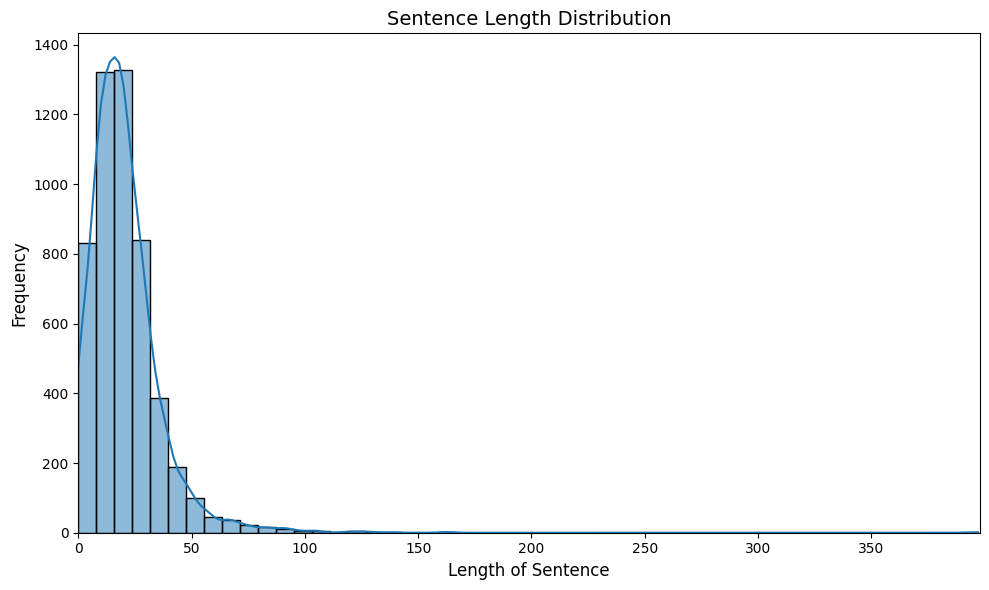

In [36]:
length_sentence = [len(s) for s in sentences]
plt.figure(figsize=(10, 6))
sns.histplot(data=length_sentence, bins=50, kde=True)
plt.xlabel('Length of Sentence', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Sentence Length Distribution', fontsize=14)
plt.xlim(0, max(length_sentence) + 1)
plt.tight_layout()
plt.show()

# Splitting & Augmentation

In [37]:
train_sentences, test_sentences = train_test_split(sentences, test_size=0.23, random_state=30)

target_tags = ["I-MISC", "B-MISC", "I-LOC", "I-ORG"]

rare_sentences = [
    s for s in train_sentences
    if any(tag.startswith(tuple(target_tags)) for word, tag in s)
]

extra_count = int(0.5 * len(rare_sentences))
extra_sentences = random.choices(rare_sentences, k=extra_count)

train_sentences = train_sentences + extra_sentences

# Apply Padding

In [38]:
max_len = 100

X_train = [[word2idx[w[0]] for w in s] for s in train_sentences]
X_train = pad_sequences(maxlen=max_len, sequences=X_train, padding="post", value=word2idx['ENDPAD'])

y_train = [[tag2idx[w[1]] for w in s] for s in train_sentences]
y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post", value=tag2idx['O'])

In [39]:
X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=word2idx['ENDPAD'])

y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx['O'])

In [40]:
print(X_train.shape)
print(X_test.shape)

(4629, 100)
(1185, 100)


# Building & Training The Model

In [41]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    mode='min'
)

In [42]:
model = Sequential()
model.add(Input(shape=(max_len,)))
model.add(Embedding(input_dim=num_words, output_dim=300))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

In [43]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 300)       │     7,959,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 100, 9)         │         2,313 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,401,509 (32.05 MB)

 Trainable params: 8,401,509 (32.05 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
labels = df['tag'].unique()
class_weights = compute_class_weight(class_weight='balanced', classes=labels, y=df['tag'])
class_weights_dict = {label: weight for label, weight in zip(labels, class_weights)}

In [45]:
sample_weights = np.ones_like(y_train, dtype=np.float32)
idx2tag = {i: tag for i, tag in enumerate(tags)}
for tag_idx, tag in idx2tag.items():
    sample_weights[y_train == tag_idx] = class_weights_dict.get(tag, 1.0)

In [46]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [47]:
history = model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test),
          callbacks=[early_stopping, reduce_lr], sample_weight=sample_weights)

Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.8263 - loss: 0.5161 - val_accuracy: 0.8956 - val_loss: 0.3108 - learning_rate: 0.0010
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.9236 - loss: 0.1583 - val_accuracy: 0.9631 - val_loss: 0.1337 - learning_rate: 0.0010
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9729 - loss: 0.0477 - val_accuracy: 0.9777 - val_loss: 0.0810 - learning_rate: 0.0010
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9878 - loss: 0.0179 - val_accuracy: 0.9785 - val_loss: 0.0775 - learning_rate: 0.0010
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9922 - loss: 0.0099 - val_accuracy: 0.9818 - val_loss: 0.0715 - learning_rate: 0.0010
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9954 - loss: 0.0060 - val_accuracy: 0.9849 - val_loss: 0.0666 - learning_rate: 0.0010
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9970 - loss: 

# Model Evaluation

In [48]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9870 - loss: 0.0747
Test Accuracy: 0.9871


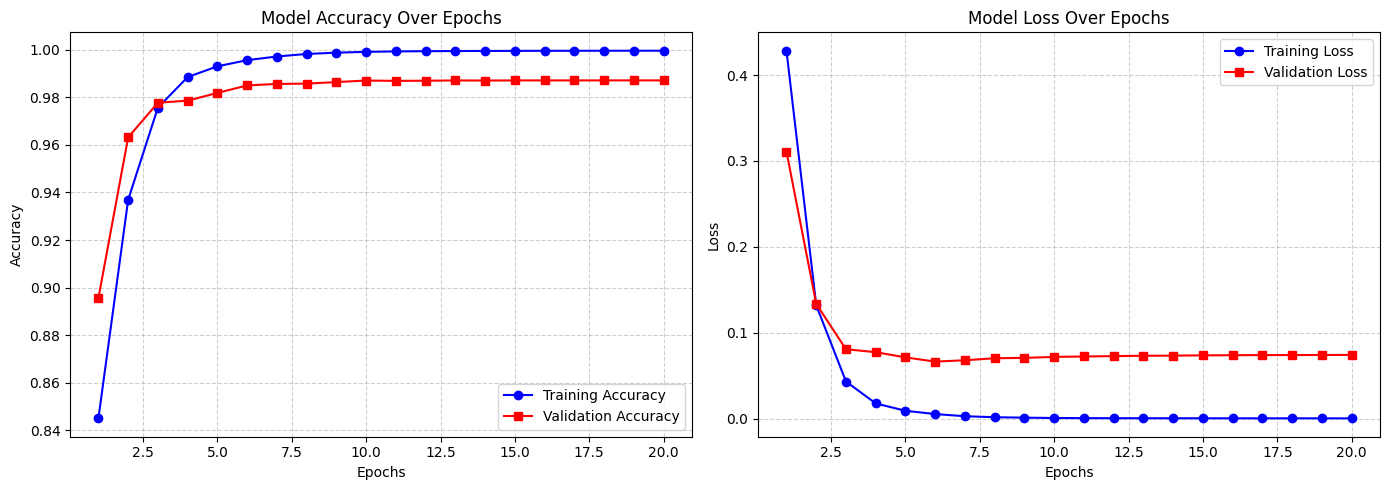

In [49]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'b-o', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r-s', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'b-o', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r-s', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [50]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=-1)
y_test_tags = [[idx2tag[idx] for idx in seq] for seq in y_test]
y_pred_tags = [[idx2tag[idx] for idx in seq] for seq in y_pred_labels]
y_true_flat = [label for seq in y_test_tags for label in seq]
y_pred_flat = [label for seq in y_pred_tags for label in seq]
print(classification_report(y_true_flat, y_pred_flat, labels=tags))

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
              precision    recall  f1-score   support

      I-PERS       0.77      0.64      0.70       646
       I-ORG       0.72      0.64      0.68       304
           O       0.99      1.00      0.99    114865
       I-LOC       0.70      0.74      0.72       137
       B-LOC       0.88      0.84      0.86      1046
      B-PERS       0.78      0.66      0.72       805
      B-MISC       0.67      0.56      0.61       192
      I-MISC       0.59      0.48      0.53       107
       B-ORG       0.71      0.69      0.70       398

    accuracy                           0.99    118500
   macro avg       0.76      0.69      0.72    118500
weighted avg       0.99      0.99      0.99    118500



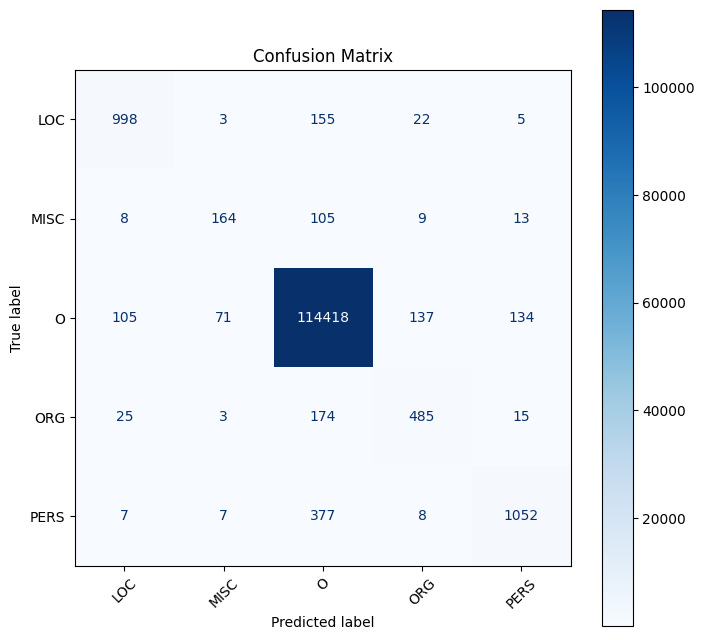

In [51]:
def simplify_label(label):
    if label == 'O':
        return 'O'
    return label.split('-')[-1]

y_true_simple = [simplify_label(label) for label in y_true_flat]
y_pred_simple = [simplify_label(label) for label in y_pred_flat]

labels = sorted(set(y_true_simple + y_pred_simple))
cm = confusion_matrix(y_true_simple, y_pred_simple, labels=labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap="Blues", ax=ax)

plt.title("Confusion Matrix")
plt.show()

# Prediction on Input Text

In [52]:
def predict(text):
    words_in_text = text.split()

    processed_words = []
    punctuations.add(".")
    for word in words_in_text:
        if word in stop_words:
            continue

        word = remove_punct(word)

        word = re.sub(r'[^\u0600-\u06FF]+', '', word)

        word = re.sub(r'\d+', '', word)

        if len(word) == 1 and word != '.':
            continue
        word = remove_definite_article(word)
        word = normalize_arabic(word)

        if word.strip() != "":
            processed_words.append(word)

    if not processed_words:
        print("There are no words after processing.")
        return

    word_indices = [word2idx.get(w, word2idx["ENDPAD"]) for w in processed_words]
    word_indices = pad_sequences([word_indices], maxlen=max_len, padding='post', value=word2idx["ENDPAD"])

    pred = model.predict(np.array(word_indices))
    pred_tags = np.argmax(pred, axis=-1)[0]

    print("{:15}\t {}\n".format("Word", "Pred"))
    print("-" * 30)
    for word, tag_idx in zip(processed_words, pred_tags[:len(processed_words)]):
        print("{:15}\t{}".format(word, tags[tag_idx]))

In [53]:
predict("شركة جوجل افتتحت مكتبًا جديدًا في مدينة دبي.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Word           	 Pred

------------------------------
شركه           	O
جوجل           	B-ORG
افتتحت         	O
مكتبا          	O
جديدا          	O
مدينه          	O
دبي            	B-LOC


In [54]:
predict("محمد صلاح هو لاعب كرة قدم مصري في فريق ليفربول.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Word           	 Pred

------------------------------
محمد           	B-PERS
صلاح           	I-PERS
لاعب           	O
كره            	O
قدم            	O
مصري           	O
فريق           	O
ليفربول        	B-ORG


In [55]:
predict("مصر تستضيف بطولة كأس العالم لكرة اليد في 2021.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Word           	 Pred

------------------------------
مصر            	B-LOC
تستضيف         	O
بطوله          	B-MISC
كاس            	I-MISC
عالم           	I-MISC
لكره           	I-MISC
يد             	O


In [56]:
predict("المنتخب المصري لكرة القدم سيشارك في كأس أمم افريقيا في المغرب 2025.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Word           	 Pred

------------------------------
منتخب          	O
مصري           	O
لكره           	O
قدم            	O
سيشارك         	O
كاس            	O
امم            	I-MISC
افريقيا        	B-LOC
مغرب           	B-LOC


# Save Model

In [57]:
model.save("ner_model.keras")

In [58]:
with open("word2idx.pkl", "wb") as f:
    pickle.dump(word2idx, f)

In [59]:
with open("tag2idx.pkl", "wb") as f:
    pickle.dump(tag2idx, f)

In [60]:
with open("tags.pkl", "wb") as f:
    pickle.dump(tags, f)

In [61]:
with open("punctuations.pkl", "wb") as f:
    pickle.dump(punctuations, f)

In [62]:
with open("stop_words.pkl", "wb") as f:
    pickle.dump(stop_words, f)